<img src="https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/images.svg" style="width: 500px;">

<h2><center> Analisis Sentimen Publik
terhadap Kegiatan Work from Home selama
Pandemi COVID-19 menggunakan Optimasi Model Klasifikasi
dengan Hyperparameter Tuning</center></h2>


<center><b>Disusun oleh</b>          : Fatihah Rahmadayana (1301174083) </center>

## 0. Import Library
Import library yang dibutuhkan dalam program ini.
<ol>
  <li><b>Pandas</b></li>
    Pandas digunakan untuk membuat tabel, mengubah dimensi data, mengecek data, dan lain sebagainya. Struktur data yang digunakan dalam library ini adalah DataFrame yang memudahkan kita untuk membaca sebuah file dengan banyak jenis format seperti file .txt, .csv, dan .tsv.
  <li><b>Numpy</b></li>
    NumPy (Numerical Python) Array adalah library Python yang fokus pada scientific computing. NumPy Array memiliki kemampuan untuk membentuk objek N-dimensional array, yang mirip dengan list pada Python.
    <li><b>Tweepy</b></li>
    Tweepy merupakan salah satu library pada python yang digunakan untuk melakukan crawling data twitter.
    <li><b>Re</b></li>
    Re (regular expression) digunakan untuk mencari ekspresi reguler yang merupakan sebuah notasi yang dapat digunakan untuk mendeskripsikan pola dari kata yang ingin dicari.
    <li><b>Sqlite3</b></li>
    Sqlite3 merupakan salah satu library yang memungkinkan untuk mengakses databse menggunakan query SQL.
    <li><b>Matplotlib</b></li>
    Matplotlib merupakan library pada Python yang digunakan untuk melakukan visualisasi data menjadi lebih rapi dan menarik. Biasanya bentuk visualisasi dengan Matplotlib berupa grafik yang memiliki satu sumbu atau lebih.
    <li><b>Seaborn</b></li>
    Seaborn merupakan library pada python yang juga digunakan untuk melakukan visualisasi data. Seaborn menyediakan tampilan yang lebih beragam dibandingkan dengan matplotlib.
    <li><b>Sastrawi</b></li>
    Sastrawi adalah library Python sederhana yang digunakan dalam pemrosesan. Library ini memungkinkan untuk mereduksi kata-kata infleksi dalam Bahasa Indonesia (Bahasa Indonesia) ke bentuk dasarnya.
    <li><b>Sklearn</b></li>
    Sklearn (Scikit-Learn) merupakan library Machine Learning open source berbasis Python yang bisa digunakan dalam Data Science. Kelebihan Scikit-Learn adalah penggunaan API yang mudah serta kecepatannya saat melakukan tolok ukur yang berbeda dalam dataset.
    <li><b>Preprocessor</b></li>
    Preprocessor merupakan salah satu library python yang memudahkan untuk membersihkan, parsing, atau tokenizing suatu tweet.
</ol>

In [1]:
import pandas as pd
import numpy as np 
import tweepy, re, sqlite3, os, random
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import preprocessor as p
from datetime import date

from emoji import UNICODE_EMOJI
import warnings
from IPython.display import clear_output

## 1. Data Collecting
Melakukan pengumpulan data yang berasal dari twitter, dengan menggunakan metode crawling. Crawling dilakukan dengan menggunakan library tweepy dan Twitter API. Data yang dikumpulkan berupa tweet ID, date, username, dan tweet. Hasil dari tahap ini adalah:
<ol>
<li><b>Data Training</b></li>
    Data yang digunakan untuk training sebanyak 5000 data. Data ini akan dilakukan pelabelan secara manual.
<li><b>Data Testing</b></li>
    Data tidak berlabel untuk dilakukan prediksi di tahap akhir program ini. Data ini berjumlah 50.000 data.
    
</ol>

In [2]:
def crawling(keyword):
    consumer_key = ""
    consumer_secret = ""
    access_token = ""
    access_token_secret = ""

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    search_words = keyword
    new_search = search_words + " -filter:retweets"

    tweets = tweepy.Cursor(api.search,
                q=new_search,
                lang="id", 
                tweet_mode='extended').items(1000)    

    items = []
    tweetId = []
    tgl = []
    username = []
    for tweet in tweets:
        items.append(tweet.full_text)
        tweetId.append(tweet.id)
        tgl.append(tweet.created_at)
        username.append(tweet.user.screen_name)

    hasil = pd.DataFrame(list(zip(tweetId,tgl,username, items)), columns=['tweetId','date','username','tweet'])
    return hasil

def save_to_csv(data, keyword):
    file_name = keyword+" "+str(date.today())+".csv"
    data.to_csv(file_name, index=False) 

In [3]:
keywords = ['wfh','workfromhome','work from home','#wfh','#workfromhome']

for keyword in keywords:
    tweets = crawling(keyword)
    save_to_csv(tweets, keyword)
    print("Keyword", keyword, "Done")
    clear_output(wait=True)
print("All keyword done")

All keyword done


## 2. Preprocessing
### 2.0. Menyiapkan Data
Membaca data yang akan digunakan. Data yang digunakan merupakan data yang sudah dilakukan pelabelan secara manual. Data tersebut kemudian dilakukan penghapusan NaN Value, serta pengubahan tipe data di setiap column pada dataset.

In [4]:
data = pd.read_csv(r"https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/data_train.csv")
data.dropna(inplace=True)
data['label'] = data['label'].astype('int')
data['tweet'] = data['tweet'].astype(str)
data.reset_index(drop=True, inplace=True)
data.head()

,tweetId,date,username,tweet,label
0,1374945386733793287,2021-03-25 04:45:00,imnteeevil,ganggu orang WFH aja bajingan !,0
1,1409154884406939652,2021-06-27 14:21:19,irmaminoris,Akhirnya ada pengumuman WFH setelah samping ka...,1
2,1387457684115390471,2021-04-28 17:24:24,hibyscu,"padahal pas wfh jam kerja makin gila, nonstop ...",0
3,1376747308012859393,2021-03-30 04:05:11,saltedcaramell6,@selphieusagi Aku lebih nyaman wfh walaupun sk...,1
4,1364770266048471040,2021-02-25 02:52:42,Widyor1st,"Da ah Udh kosong lg kepala, kerja kerja. Untun...",1


### 2.1. Perluasan Akronim

Fungsi ini digunakan untuk memperluas akronim yang terdapat pada tweets. Akronim diperluas berdasarkan kamus yang digunakan (<b>acronym.txt</b>).

In [5]:
warnings.filterwarnings('ignore')
acronym = pd.read_csv(r'https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/dataset/acronym.txt', delimiter=' =', encoding='utf8', header=None)

tmp = []
for i in acronym[1]:
    tmp.append(i.strip())
    
acronym[1] = tmp
acronym = dict(acronym.values)

def replace_acronym(tweet):
    return ' '.join(acronym.get(x, x) for x in tweet.split())

### 2.2. Penerjemahan Kata Slang

Fungsi ini digunakan untuk menerjemahkan kata slang yang terdapat pada tweets, berdasarkan kamus kata slang yang digunakan (<b>kamusalay.csv</b>).


In [6]:
slang = pd.read_csv(r'https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/dataset/kamusalay.csv', encoding='utf8', header=None)

tmp = []
for i in slang[1]:
    tmp.append(i.strip())
    
slang[1] = tmp
slang = dict(slang.values)

def replace_slang(tweet):
    return ' '.join(slang.get(x.lower(), x) for x in tweet.split())

### 2.3. Penerjemahan Emoji

Fungsi ini digunakan untuk menerjemahkan emoji yang terdapat pada tweets. Emoji diterjemahkan sesuai maknanya masing masing, dengan menggunakan kamus <b>emoji.txt</b>.

In [7]:
emoji = pd.read_csv(r'https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/dataset/emoji.txt', encoding='utf8', header=None)

tmp = []
for i in emoji[1]:
    tmp.append(i.strip())
    
emoji[1] = tmp
emoji = dict(emoji.values)

def is_emoji(s):
    return s in UNICODE_EMOJI

def replace_emoji(tweet):
    result = ''
    for char in tweet:
        if is_emoji(char):
            result = result + ' ' + emoji.get(char, char)
        else:
            result += emoji.get(char, char)
    return result.strip()

### 2.4. Data Cleaning

Fungsi ini merupakan fungsi utama yang digunakan pada tahap preprocessing. Pada fungsi ini dilakukan pemanggilan fungsi-fungsi lain yang telah di deklarasikan sebelumnya seperti <b>replace_acronym()</b>, <b>replace_slang()</b>, <b>replace_emoji()</b>, serta pemanggilan beberapa method pada library yang digunakan.


In [8]:
# get stopwords
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# initiate stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# tweet-preprocess
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.NUMBER)

def data_cleaning(data): 

    cek = []
    for i, tweet in enumerate (data['tweet']):
        # replace acronym
        tweet = replace_acronym(str(tweet))  
        
        tweet = tweet.lower()
        
        # data cleansing
        tweet = p.clean(tweet)
        tweet = re.sub("(@[^\s]+|@[A-Za-z0-9]+)", " ", tweet)
        tweet = re.sub("\d+", "", tweet)
        
        # remove duplicate char
        tweet = re.sub(r'(.)\1+$', r'\1', tweet)

        # replace slang words
        tweet = replace_slang(str(tweet))              
        
        # replace emoji
        tweet = replace_emoji(str(tweet))        
        
        # stopword removal
        tweet = stopword.remove(tweet)
        
        # stemming
        tweet = stemmer.stem(tweet)
                
        # append
        cek.append(tweet.strip())
        
        clear_output(wait=True)
        print("Progress ", str((i+1)/len(data['tweet'])*100) + " %" )
    data['cleantweet'] = cek
    return data

In [9]:
data = data_cleaning(data)
data.head()

Progress  100.0 %


,tweetId,date,username,tweet,label,cleantweet
0,1374945386733793287,2021-03-25 04:45:00,imnteeevil,ganggu orang WFH aja bajingan !,0,ganggu orang wfh bajing
1,1409154884406939652,2021-06-27 14:21:19,irmaminoris,Akhirnya ada pengumuman WFH setelah samping ka...,1,akhir umum wfh samping kantor positif covid ti...
2,1387457684115390471,2021-04-28 17:24:24,hibyscu,"padahal pas wfh jam kerja makin gila, nonstop ...",0,padahal pas wfh jam kerja makin gila nonstop s...
3,1376747308012859393,2021-03-30 04:05:11,saltedcaramell6,@selphieusagi Aku lebih nyaman wfh walaupun sk...,1,aku lebih nyaman wfh walaupun sekarang full wf...
4,1364770266048471040,2021-02-25 02:52:42,Widyor1st,"Da ah Udh kosong lg kepala, kerja kerja. Untun...",1,daerah ah kosong kepala kerja kerja untung wfh...


### 2.5. Simpan Hasil Preprocessing

Dataset hasil preprocessing disimpan dalam file <b>clean_data_train.csv</b>.

In [10]:
data.to_csv("clean_data_train.csv", index=False)

### Read Data Hasil Preprocessing

In [11]:
data = pd.read_csv(r"https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/clean_data_train.csv")
data.head()

,tweetId,date,username,tweet,label,cleantweet
0,1374945386733793287,2021-03-25 04:45:00,imnteeevil,ganggu orang WFH aja bajingan !,0,ganggu orang wfh bajing
1,1409154884406939652,2021-06-27 14:21:19,irmaminoris,Akhirnya ada pengumuman WFH setelah samping ka...,1,akhir umum wfh samping kantor positif covid ti...
2,1387457684115390471,2021-04-28 17:24:24,hibyscu,"padahal pas wfh jam kerja makin gila, nonstop ...",0,padahal pas wfh jam kerja makin gila nonstop s...
3,1376747308012859393,2021-03-30 04:05:11,saltedcaramell6,@selphieusagi Aku lebih nyaman wfh walaupun sk...,1,aku lebih nyaman wfh walaupun sekarang full wf...
4,1364770266048471040,2021-02-25 02:52:42,Widyor1st,"Da ah Udh kosong lg kepala, kerja kerja. Untun...",1,daerah ah kosong kepala kerja kerja untung wfh...


### Visualisasi Perbandingan Data

Menampilkan diagram batang perbandingan jumlah data berlabel negatif dan positif.

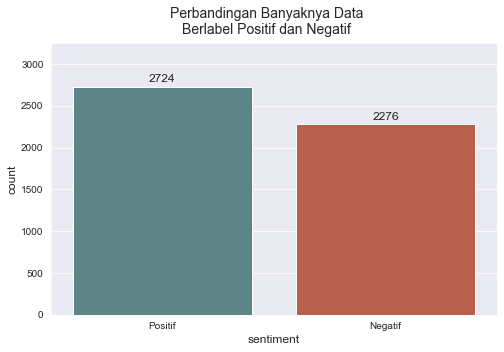

In [12]:
sns.set_style('darkgrid')

fig = plt.figure(figsize=(8,5))
plots = sns.barplot(x = ['Positif', 'Negatif'], y = data['label'].value_counts(), palette=['#588b8b','#c8553d'])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
plt.ylim(0, 3250)    
plt.xlabel("sentiment", size=12)
plt.ylabel("count", size=12)
plt.suptitle("Perbandingan Banyaknya Data\nBerlabel Positif dan Negatif", size=14)
plt.savefig("visualisasi.png")
plt.show()

## 3. Hyperparameter Tuning

Mengoptimasi hyperparameter yang digunakan pada Support Vector Machine. Algoritma hyperparameter tuning yang digunakan adalah <b>RandomizedSearchCV()</b> dari <b>scikit-learn</b>. Algoritma ini mengacak (random) parameter yang telah ditentukan, kemudian mengevaluasi hasil berdasarkan metriks accuracy dengan cross validation.


### Support Vector Machine

Algoritma yang digunakan adalah Support Vector Classifier (SVC), dengan mengoptimasi beberapa parameter berikut.
<ol>
<li><b>Kernel</b></li>
    Digunakan untuk menentukan jenis kernel yang akan digunakan dalam algoritma. Dalam program ini menggunakan parameter <b>linear</b> dan <b>rbf</b>.
<li><b>C </b></li>
    C merupakan parameter regularisasi. Parameter ini digunakan mengontrol trade off antara margin dan error klasifikasi ξ atau nilai kesalahan pada klasifikasi.
<li><b>Gamma </b></li>    
    Gamma merupakan parameter untuk hyperplanes non-linier (salah satunya adalah rbf). Parameter ini menentukan seberapa jauh pengaruh dari suatu sample.
    
    
</ol>

In [14]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('svc', svm.SVC())])

parameters = [
 {'svc__C': [0.1, 1, 10, 100, 1000], 'svc__kernel': ['linear']},
 {'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'svc__kernel': ['rbf']},
]

rs_svm = RandomizedSearchCV(n_iter = 20, estimator = pipe, scoring='f1_weighted', 
                            param_distributions = parameters, random_state=123, cv=10, n_jobs=-1, verbose=10)

rs_svm.fit(data['cleantweet'], data['label'])
print("Hyperparameter terbaik :", rs_svm.best_params_)
print("Nilai akurasi terbaik :", rs_svm.best_score_)
hasil = pd.DataFrame(rs_svm.cv_results_)
hasil.to_csv("hasil_cross_validation.csv")


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5

Hyperparameter terbaik : {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__C': 100}
Nilai akurasi terbaik : 0.8336171993179364


## 4. Predict Unlabeled Dataset

Memprediksi dataset yang tidak berlabel dengan menggunakan metode yang telah diuji sebelumnya.

### 4.0. Read Data Tidak Berlabel
Membaca data tidak berlabel yang akan diprediksi nilai sentimennya.

In [15]:
unlabeled_df = pd.read_csv(r"https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/dataset/unlabeled_data.csv")
unlabeled_df.head()

,tweetId,date,username,tweet
0,1368762547189481475,2021-03-08 03:16:36,Langgard,"Di masa pandemi kita jadi kurang bergerak, lat..."
1,1368756182337253376,2021-03-08 02:51:18,primadigitalso1,Tekan biaya industri anda dengan menggunakan V...
2,1368613542102933506,2021-03-07 17:24:30,anastasianitap,@HabHesty Iya bu sama. Untung besok dapat jata...
3,1368247086471213058,2021-03-06 17:08:20,keroropanda,#WFH\nMAGANG DI TIKET .COM\n\nSegera kirimkan ...
4,1368157679382753282,2021-03-06 11:13:04,RidwanAffiliate,Mentoring Lengkap tentang bagaimana membuat La...


### 4.1. Preprocessing

Membersihkan data sesuai dengan hasil pengujian skenario terhadap metode preprocessing. Hasil pengujian skenario menunjukkan bahwa seluruh metode preprocessing bekerja dengan baik.

In [16]:
unlabeled_df.dropna(inplace=True)
unlabeled_df['tweet'] = unlabeled_df['tweet'].astype(str)
unlabeled_df.reset_index(drop=True, inplace=True)

In [17]:
unlabeled_df = data_cleaning(unlabeled_df)
unlabeled_df.head()

Progress  100.0 %


,tweetId,date,username,tweet,cleantweet
0,1368762547189481475,2021-03-08 03:16:36,Langgard,"Di masa pandemi kita jadi kurang bergerak, lat...",masa pandemi jadi kurang gerak latih kecil jad...
1,1368756182337253376,2021-03-08 02:51:18,primadigitalso1,Tekan biaya industri anda dengan menggunakan V...,tekan biaya industri guna vcloudpoint komputer...
2,1368613542102933506,2021-03-07 17:24:30,anastasianitap,@HabHesty Iya bu sama. Untung besok dapat jata...,iya bu sama untung besok jatah lega
3,1368247086471213058,2021-03-06 17:08:20,keroropanda,#WFH\nMAGANG DI TIKET .COM\n\nSegera kirimkan ...,magang daerah istimewa tiket com segera kirim ...
4,1368157679382753282,2021-03-06 11:13:04,RidwanAffiliate,Mentoring Lengkap tentang bagaimana membuat La...,mentoring lengkap bagaimana buat landing page ...


In [18]:
unlabeled_df.to_csv("clean_unlabeled_data.csv", index=False)

#### Read Clean Unlabeled Data

In [19]:
clean_data = pd.read_csv(r"https://raw.githubusercontent.com/fatihahrhm/Tugas-Akhir/main/clean_unlabeled_data.csv")
clean_data.head()

,tweetId,date,username,tweet,cleantweet
0,1368762547189481475,2021-03-08 03:16:36,Langgard,"Di masa pandemi kita jadi kurang bergerak, lat...",masa pandemi jadi kurang gerak latih kecil jad...
1,1368756182337253376,2021-03-08 02:51:18,primadigitalso1,Tekan biaya industri anda dengan menggunakan V...,tekan biaya industri guna vcloudpoint komputer...
2,1368613542102933506,2021-03-07 17:24:30,anastasianitap,@HabHesty Iya bu sama. Untung besok dapat jata...,iya bu sama untung besok jatah lega
3,1368247086471213058,2021-03-06 17:08:20,keroropanda,#WFH\nMAGANG DI TIKET .COM\n\nSegera kirimkan ...,magang daerah istimewa tiket com segera kirim ...
4,1368157679382753282,2021-03-06 11:13:04,RidwanAffiliate,Mentoring Lengkap tentang bagaimana membuat La...,mentoring lengkap bagaimana buat landing page ...


### 4.2. Predict

Memprediksi nilai sentimen untuk setiap tweets dengan model terbaik. 

In [20]:
predicted = rs_svm.predict(clean_data['cleantweet'].astype(str))
predicted

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [21]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

clean_data['sentimen'] = predicted
clean_data[['tweet','cleantweet','sentimen']]

,tweet,cleantweet,sentimen
0,"Di masa pandemi kita jadi kurang bergerak, latihan kecil ini jadi solusi buat kita dirumah.\n\n#herballife #hidupsehat #herbal #racikanalami #gayahidupsehat #hidupsehat #lawancorona #wfh https://t.co/EJOHqCUnGP",masa pandemi jadi kurang gerak latih kecil jadi solusi buat rumah,1
1,Tekan biaya industri anda dengan menggunakan Vcloudpoint. Komputer dengan daya 5 watt yang akan menunjang kinerja dan produktifitas industri anda.\n\nVcloudPoint\nMake desktop computing extremely simple and affordable.\n\n#vcloudpoint\n#vcloudpointindonesia\n#komputer\n#workfromhome\n#WFH https://t.co/O1b4pHLbPz,tekan biaya industri guna vcloudpoint komputer dengan daya watt akan tunjang kerja produktivitas industri anda vcloudpoint make desktop computing extremely simple and affordable,1
2,@HabHesty Iya bu sama. Untung besok dapat jatah #wfh 😌,iya bu sama untung besok jatah lega,1
3,#WFH\nMAGANG DI TIKET .COM\n\nSegera kirimkan Portofolio dan CV terbaru kamu ke putu.wijaya@tiket.com https://t.co/Dgs0flQCM1,magang daerah istimewa tiket com segera kirim portofolio curriculum vitae baru kamu putu wijaya com,1
4,"Mentoring Lengkap tentang bagaimana membuat Landing Page Secara Live, Kelas Ditutup 2 Hari Lagi,,\nSelengkapnya cek https://t.co/EiKUKKmECU\n\n#landingpage #bisnisonline #cuandariinternet #twitterbisnis #DigitalMarketing #MarketingTwitter #WFH #kelasonline https://t.co/d64aPHgrqc",mentoring lengkap bagaimana buat landing page live kelas tutup hari lagi lengkap cek,1
...,...,...,...
56002,"@FIRMANSYAHALDI8 km kan masi ikut organisasi, wlopun workfromhome wkwk",kilometer kan ikut organisasi walaupun workfromhome wkwk,1
56003,@rofvania gamau satu workspace tapi mau satu workfromhome.. heee,mau satu workspace mau satu workfromhome he,1
56004,"next week workfromhome , seminggu punya kerja pun tak boleh settle dekat office .",next week workfromhome minggu punya kerja tak settle dekat office,1
56005,"Hai guys! Buat kamu yang workfromhome Fingerspot iO menjadi solusi untuk produktivitas kamu. \nBerbagai keunggulan Fingerspot iO yang bisa kamu dapatkan, diantaranya:\n- Absensi kehadiran via ponsel / mesin - Pantau kehadiran dari ponsel\n- Lihat timeline dan peta scan karyawan \nDll https://t.co/njQ2hzWmgY",hai guys buat kamu workfromhome fingerspot io jadi solusi produktivitas kamu bagai unggul fingerspot io bisa kamu dapat antara - absensi hadir via telepon seluler mesin - pantau hadir telepon seluler - lihat lini masa peta scan karyawan dulu,1


### 4.3. Hasil Prediksi

Hasil dari prediksi pada tahap sebelumnya, ditampilkan dalam bentuk diagram batang dan diagram lingkaran.

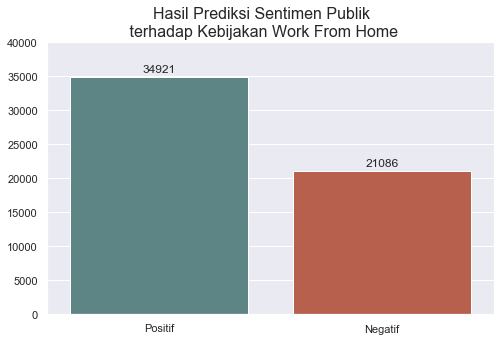

In [32]:
import seaborn as sns

sns.set(style="darkgrid")

x = ["Positif", "Negatif"]
y = list(clean_data.sentimen.value_counts())

fig = plt.figure(figsize=(8, 5))
plots = sns.barplot(x = x, y = y, palette=['#588b8b','#c8553d'])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
    
plt.ylim(0, 40000)  
fig.suptitle('Hasil Prediksi Sentimen Publik \n terhadap Kebijakan Work From Home \n', fontsize=16)
plt.savefig("hasil.png")
plt.show()

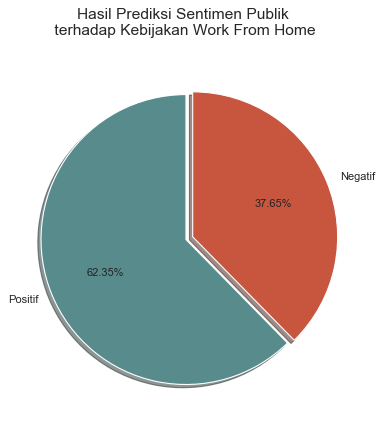

In [23]:
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize=(8, 6), dpi=80)
plt.pie(clean_data.sentimen.value_counts(), labels = ["Positif","Negatif"], startangle=90, autopct='%1.2f%%', 
        colors=['#588b8b','#c8553d'], explode=[0.05,0], shadow=True)

fig2.suptitle('Hasil Prediksi Sentimen Publik \n terhadap Kebijakan Work From Home \n', fontsize=14)
plt.savefig("hasil 2.png")
plt.show()